In [1]:
import numpy as np
import pandas as pd
import time
from scipy.linalg import solve, kron
from scipy import stats
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


Reproduction to regulatory figures for validation of calibration method.

Using grid 1~10, 20, 30 and data after Jan 2010.

Considering the yield control curve policy by held by Japan Bank and supply of 40y JGB, using different grid (e.g. 1, 5, 7, 10, 15, 20, 25, 30, 40) and longer period may be better.

## Kalman filter calibration

In [ ]:
# ================================
# 1. initial settings
# ================================
# set wsdata to current directry
wsdata = './'
#wsdata = '/Users/taka/Library/CloudStorage/GoogleDrive-ktaka8128@gmail.com/My Drive/Princeton/Spring2025/COS513/Final/'
inputfile = 'DNSinput_JPY_regulation.csv'
calibrationstart = 521 # use the data from Jan 2010 to reproduce the regulatory figures
calibrationend = 1213

outputfile = 'DNSoutput_JPY_long_calibration_202303_regulation.csv'
LSCoutputfile = 'DNSoutput_JPY_long_LSC_202303_regulation.csv'
outdetail = True
outputdetailfile = 'DNSoutput_JPY_long_calibration_detail_202303_regulation.csv'

# initial parameters
para0 = np.concatenate((
    np.array([0.24]),
    np.array([4.30e-02,2.70e-02,3.00e-02,  3.20e-02, 3.60e-02,  3.70e-02,
        3.70e-02,  3.80e-02,  3.80e-02,  5.10e-02,
        2.20e-01,  3.30e-01]),
    np.array([0.9938, 0.99310, 0.9907]),
    np.array([2.31808, -2.285, -3.00]),
    np.array([0.072, -0.07, 0.02, -0.092, -0.06, 0.0970])
))


# parameter update scale
paraStep = np.concatenate((
    np.array([-40]),
    np.repeat(-4, 10),
    np.repeat(-3, 2),
    np.repeat(-5, 3),
    np.repeat(-3, 3),
    np.repeat(-4, 6)
))
# grid：Nelson–Siegel grids
grid = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30])
gridn = len(grid)
lambdastep = np.arange(0.23, 0.25 + 0.01, 0.01)
maxstepn = 50000
tstep = 52

# ================================
# 2. utility functions
# ================================

def lyapunov(N, phi, Q):
    # Lyapunov解： P = solve((I - kron(phi,phi)), vec(Q)) を N×N行列にリシェイプ
    I = np.eye(N * N)
    K_mat = np.kron(phi, phi)
    vecP = np.linalg.solve(I - K_mat, Q.flatten())
    return vecP.reshape(N, N)

def Nelson_Siegel_factor_loadings(l, m):
    # m はリストまたは配列
    m = np.array(m)
    column1 = np.ones(len(m))
    column2 = (1 - np.exp(-l * m)) / (l * m)
    column3 = column2 - np.exp(-l * m)
    lambmat = np.column_stack((column1, column2, column3))
    return lambmat

# R の Kfilter 関数の Python 版（0-indexed版）
def Kfilter(logLik, N, T, Y, Z, a_t, P_t, H, a_tt, P_tt, v2, v1, phi, mu, Q, prev, M, Yf, lik):
    for t in range(T):
        v = Y[t, :] - Z @ a_t[t, :]
        F = Z @ P_t[t, :, :] @ Z.T + H
        detF = np.linalg.det(F)
        if detF <= 1e-30 or np.isnan(detF) or np.isinf(detF):
            logLik = -10**15
            break
        else:
            F_inv = np.linalg.inv(F)
            logLik = logLik - 0.5 * (np.log(detF) + v.T @ F_inv @ v)
        a_tt[t, :] = a_t[t, :] + P_t[t, :, :] @ Z.T @ F_inv @ v
        P_tt[t, :, :] = P_t[t, :, :] - P_t[t, :, :] @ Z.T @ F_inv @ Z @ P_t[t, :, :]
        v1[t, :] = Z @ a_tt[t, :]
        v2[t, :] = Y[t, :] - Z @ a_tt[t, :]
        a_t[t+1, :] = phi @ a_tt[t, :] + (np.eye(N) - phi) @ mu.flatten()
        P_t[t+1, :, :] = phi @ P_tt[t, :, :] @ phi.T + Q
    if prev:
        if t > (T - 1):
            for m_i in range(1, M+1):
                Yf[t + m_i, :] = Z @ a_t[t + m_i, :]
                a_tt[t + m_i, :] = a_t[t + m_i, :]
                P_tt[t + m_i, :, :] = P_t[t + m_i, :, :]
                a_t[t + m_i + 1, :] = phi @ a_tt[t + m_i, :] + (np.eye(N) - phi) @ mu.flatten()
                P_t[t + m_i + 1, :, :] = phi @ P_tt[t + m_i, :, :] @ phi.T + Q
    if lik:
        return -logLik
    else:
        return {'a_tt': a_tt, 'a_t': a_t, 'P_tt': P_tt, 'P_t': P_t, 'v2': v2, 'v1': v1, 'Yf': Yf}

def kalman(para, Y, lik, prev, ahead, grid):
    l = para[0]
    m = grid  # gridはNelson–Siegel用の m の値のリスト
    mlen = len(m)
    M = ahead
    if prev:
        T = Y.shape[0]
        Yf = Y.copy()
        Yf[T-M:T, :] = np.nan
        Y = Y[:T-M, :]
        T = Y.shape[0]
    else:
        T = Y.shape[0]
        Yf = None
    
    pars = {}
    W = Y.shape[1]
    N = 3
    pars['mu'] = np.full((N, 1), np.nan)
    pars['phi'] = np.eye(N)
    pars['H'] = np.eye(W)
    pars['Q'] = np.eye(N)
    
    # Loading matrix
    pars['Z'] = Nelson_Siegel_factor_loadings(l, m)
    
    for i in range(mlen):
        pars['H'][i, i] = para[1 + i]
    H = pars['H'] ** 2
    
    # VAR(1) coefficient matrix
    pars['phi'][0, 0] = para[mlen+1]
    pars['phi'][0, 1] = 0
    pars['phi'][0, 2] = 0
    pars['phi'][1, 0] = 0
    pars['phi'][1, 1] = para[mlen+2]
    pars['phi'][1, 2] = 0
    pars['phi'][2, 0] = 0
    pars['phi'][2, 1] = 0
    pars['phi'][2, 2] = para[mlen+3]
    
    pars['mu'][0, 0] = para[mlen+4]
    pars['mu'][1, 0] = para[mlen+5]
    pars['mu'][2, 0] = para[mlen+6]
    
    pars['Q'][0, 0] = para[mlen+7]
    pars['Q'][1, 0] = para[mlen+8]
    pars['Q'][1, 1] = para[mlen+9]
    pars['Q'][2, 0] = para[mlen+10]
    pars['Q'][2, 1] = para[mlen+11]
    pars['Q'][2, 2] = para[mlen+12]
    
    Q = pars['Q'] @ pars['Q'].T
    
    # Initialize matrices
    if prev:
        a_t = np.full((T+M, N), np.nan)
        a_tt = np.full((T, N), np.nan)
        P_t = np.full((T+M, N, N), np.nan)
        P_tt = np.full((T, N, N), np.nan)
    else:
        a_t = np.full((T+1, N), np.nan)
        a_tt = np.full((T, N), np.nan)
        P_t = np.full((T+1, N, N), np.nan)
        P_tt = np.full((T, N, N), np.nan)
    v1 = np.full((T, W), np.nan)
    v2 = np.full((T, W), np.nan)
    
    if prev and Yf is None:
        Yf = Y.copy()
    
    a_t[0, :] = pars['mu'].flatten()
    P_t[0, :, :] = lyapunov(N, pars['phi'], Q)
    
    logLik = -0.5 * T * W * math.log(2 * math.pi)
    
    out = Kfilter(logLik, N, T, Y, pars['Z'], a_t, P_t, H, a_tt, P_tt, v2, v1, pars['phi'], pars['mu'], Q, prev, M, Yf, lik)
    return out

# ================================
# 3. load the data
# ================================
data0 = pd.read_csv(wsdata + inputfile, header=0, index_col=0, encoding='cp1252')
data0.index = pd.to_datetime(data0.index)
data = data0.iloc[calibrationstart:calibrationend, :].values * 100

# ================================
# 4. calibration
# ================================
resultsall = []
results = []

for k in lambdastep:
    para0[0] = k
    print(k)
    startTime = time.time()
    
    NoP = len(para0)
    lik0 = kalman(para=para0, Y=data, lik=True, prev=False, ahead=1, grid=grid)
    
    paraNext = para0.copy()
    likNext = lik0
    
    for j in range(1, maxstepn+1):
        if j % 1000 == 0:
            print(j)
        i = j % NoP  # i in 0,...,NoP-1
        paraP = paraNext.copy()
        paraM = paraNext.copy()
        paraP[i] = paraNext[i] + 10.0**(paraStep[i])
        paraM[i] = paraNext[i] - 10.0**(paraStep[i])
        
        likP = kalman(para=paraP, Y=data, lik=True, prev=False, ahead=1, grid=grid)
        likN = likNext
        likM = kalman(para=paraM, Y=data, lik=True, prev=False, ahead=1, grid=grid)
        
        if likP < likN:
            paraNext = paraP.copy()
            likNext = likP
        elif likM < likN:
            paraNext = paraM.copy()
            likNext = likM
        
        resultsall.append(np.concatenate(([j], paraNext, [likNext])))
        
        if j > NoP+1 and resultsall[-1][gridn+15-1] == resultsall[-NoP][gridn+15-1]:
            break
    
    results.append(np.concatenate(([j], paraNext, [likNext])))
    endTime = time.time()
    print(endTime - startTime)

resultsall = np.array(resultsall)
results = np.array(results)
min_index = np.argmin(results[:, gridn+15-1])
minresults = results[min_index, :]
pd.DataFrame(minresults.reshape(1,-1)).to_csv(wsdata + outputfile, index=False)

if outdetail:
    pd.DataFrame(resultsall).to_csv(wsdata + outputdetailfile, index=False)

paratest = minresults[1:(gridn+15-1)]
LSCresult = kalman(para=paratest, Y=data, lik=False, prev=False, ahead=1, grid=grid)
pd.DataFrame(LSCresult['a_tt']).to_csv(wsdata + LSCoutputfile, index=False)


0.23
1000
2000
3000
4000
191.76390290260315
0.24000000000000002
1000
2000
3000
168.3337230682373
0.25
1000
2000
3000
4000
5000
6000
310.7900960445404


In [6]:
minresults

array([ 4.21400000e+03,  2.30000000e-01,  4.22000000e-02,  2.64000000e-02,
        2.94000000e-02,  3.14000000e-02,  3.53000000e-02,  3.64000000e-02,
        3.64000000e-02,  3.74000000e-02,  3.74000000e-02,  5.04000000e-02,
        2.14000000e-01,  3.32000000e-01,  9.95150000e-01,  9.94770000e-01,
        9.92380000e-01,  2.26908000e+00, -2.25100000e+00, -2.91400000e+00,
        7.18000000e-02, -7.02000000e-02,  1.89000000e-02, -8.11000000e-02,
       -6.02000000e-02,  9.50000000e-02, -1.41093029e+04])

## ICS risk calculation

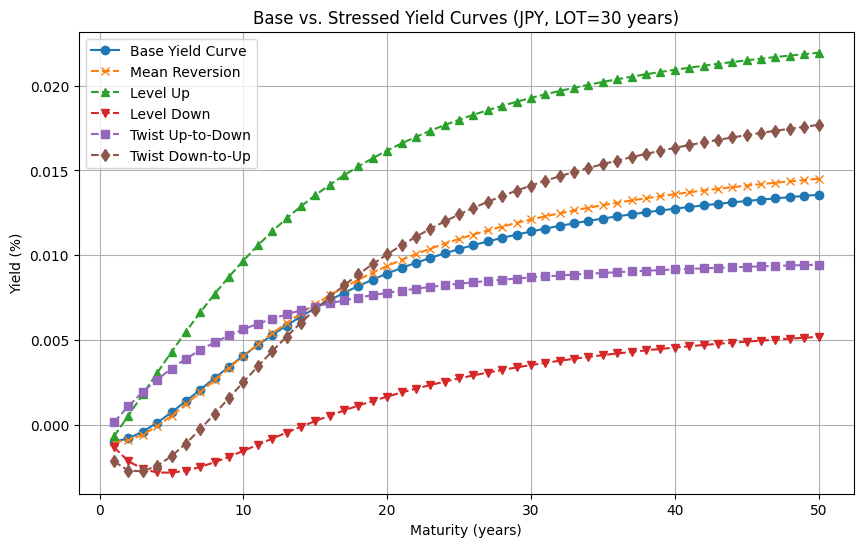


[LSC Parameters]
lambda: 0.2300
mu: [ 0.0226908 -0.02251   -0.02914  ]
K: [0.2522  0.27196 0.39624]
LSC Parameters: [ 0.01685006 -0.01775703 -0.01999596]
level_up_scenario: [-0.00354229  0.00388176 -0.00052677]
twist_scenario: [-0.0024341   0.00243476  0.00716553]


In [ ]:
# ================
# 1. utility functions
# ================
def ns_loadings(tau, lam):
    level = 1.0
    slope = (1 - np.exp(-lam * tau)) / (lam * tau) if tau > 1e-12 else 1.0
    curvature = slope - np.exp(-lam * tau)
    return np.array([level, slope, curvature])

maturities = [str(i) for i in range(1, 51)]
maturities_float = np.array([float(m) for m in maturities])

def lyapunov(N, phi, Q):
    I = np.eye(N * N)
    K_mat = np.kron(phi, phi)
    vecP = np.linalg.solve(I - K_mat, Q.flatten())
    return vecP.reshape(N, N)

def Nelson_Siegel_factor_loadings(l, m):
    m = np.array(m)
    column1 = np.ones(len(m))
    column2 = (1 - np.exp(-l * m)) / (l * m)
    column3 = column2 - np.exp(-l * m)
    return np.column_stack((column1, column2, column3))

beta_calibrated = LSCresult['a_tt'][-1, :]/100

LOT = 30
lambda_val = minresults[1]
K_est = (np.ones(3) - minresults[14:17])*tstep
mu_est = minresults[17:20]/100

def compute_yield_curve(beta, lam, tau_array):
    return np.array([beta @ ns_loadings(t, lam) for t in tau_array])
base_yields = compute_yield_curve(beta_calibrated, lambda_val, maturities_float)

# ================
# 2. compute yield curves for ICS risk calculation
# ================
# Mean Reversion
Delta = (1 - np.exp(-K_est)) * (mu_est - beta_calibrated)
shift_curve_mr = np.array([np.dot(Delta, ns_loadings(t, lambda_val)) for t in maturities_float])
stressed_yields_mr = base_yields + shift_curve_mr

def build_M(K, Sigma):
    SS = Sigma @ Sigma.T
    K_diag = np.array(K)
    out = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            kij = K_diag[i] + K_diag[j]
            out[i, j] = (1 - np.exp(-kij)) / kij if kij > 1e-12 else 0.0
    SSout = SS * out
    M = np.linalg.cholesky(SSout)
    return M

def build_N_diag(LOT, a, b):
    return np.diag([LOT, a, b])

def sum_slope_curve(lam, LOT):
    s = 0.0
    for tau in range(1, LOT+1):
        s += ns_loadings(tau, lam)[1]
    return s

def sum_curvature_curve(lam, LOT):
    s = 0.0
    for tau in range(1, LOT+1):
        s += ns_loadings(tau, lam)[2]
    return s

def calc_theta(lam, LOT, M_, e1, e2):
    sum_h1 = 0.0
    sum_h2 = 0.0
    for tau in range(1, LOT+1):
        load = ns_loadings(tau, lam)
        h1 = load @ (M_ @ e1)
        h2 = load @ (M_ @ e2)
        sum_h1 += h1
        sum_h2 += h2
    if abs(sum_h1) < 1e-12:
        return np.pi/2 if sum_h2 > 0 else -np.pi/2
    return np.arctan(sum_h2/sum_h1)

def level_up_scenario(K, Sigma, lam, LOT):
    M_ = build_M(K, Sigma)
    a_ = sum_slope_curve(lam, LOT)
    b_ = sum_curvature_curve(lam, LOT)
    N_ = build_N_diag(LOT, a_, b_)
    NM = N_ @ M_
    NtN = NM @ NM.T
    eigvals, eigvecs = np.linalg.eig(NtN)
    idx = np.argsort(eigvals)[::-1]
    e1 = eigvecs[:, idx[0]]
    e2 = eigvecs[:, idx[1]]
    theta_ = calc_theta(lam, LOT, M_, e1, e2)
    Me1 = M_ @ e1
    Me2 = M_ @ e2
    sl_vec = np.cos(theta_) * Me1 + np.sin(theta_) * Me2
    load_LOT = ns_loadings(LOT, lam)
    shift_LOT = np.dot(sl_vec, load_LOT)
    s_ = 1.0 if shift_LOT >= 0 else -1.0
    return sl_vec, s_, theta_

Q = np.zeros((3, 3))
Q[0, 0] = minresults[20]*np.sqrt(tstep)/100
Q[1, 0] = minresults[21]*np.sqrt(tstep)/100
Q[1, 1] = minresults[22]*np.sqrt(tstep)/100
Q[2, 0] = minresults[23]*np.sqrt(tstep)/100
Q[2, 1] = minresults[24]*np.sqrt(tstep)/100
Q[2, 2] = minresults[25]*np.sqrt(tstep)/100
M_est = build_M(K_est, Q)
sl_vector, s_sign, theta_val = level_up_scenario(K_est, Q, lambda_val, LOT)

n_inv = norm.ppf(0.995)

tau_list = maturities_float
shift_curve_level = []
for tau in tau_list:
    load = ns_loadings(tau, lambda_val)
    shift = np.dot(sl_vector, load)
    shift_curve_level.append(s_sign * n_inv * shift)
shift_curve_level = np.array(shift_curve_level)
stressed_yields_level_up = base_yields +  shift_curve_level
stressed_yields_level_down = base_yields - shift_curve_level

def twist_scenario_parameters(K, Sigma, lam, LOT):
    M_ = build_M(K, Sigma)
    a_ = sum_slope_curve(lam, LOT)
    b_ = sum_curvature_curve(lam, LOT)
    N_ = build_N_diag(LOT, a_, b_)
    NM = N_ @ M_
    NtN = NM @ NM.T
    eigvals, eigvecs = np.linalg.eig(NtN)
    idx = np.argsort(eigvals)[::-1]
    e1 = eigvecs[:, idx[0]]
    e2 = eigvecs[:, idx[1]]
    theta_ = calc_theta(lam, LOT, M_, e1, e2)
    twist_vector = np.cos(theta_)*(M_ @ e2) - np.sin(theta_)*(M_ @ e1)
    return twist_vector, theta_

twist_vector, theta_twist = twist_scenario_parameters(K_est, Q, lambda_val, LOT)
shift_curve_twist = np.array([np.dot(twist_vector, ns_loadings(t, lambda_val)) for t in tau_list])
shift_curve_twist *= n_inv
stressed_yields_twist_up_to_down = base_yields +  shift_curve_twist
stressed_yields_twist_down_to_up = base_yields -  shift_curve_twist


plt.figure(figsize=(10,6))
plt.plot(maturities_float, base_yields, label="Base Yield Curve", marker='o')
plt.plot(maturities_float, stressed_yields_mr, label="Mean Reversion", marker='x', linestyle="--")
plt.plot(maturities_float, stressed_yields_level_up, label="Level Up", marker='^', linestyle="--")
plt.plot(maturities_float, stressed_yields_level_down, label="Level Down", marker='v', linestyle="--")
plt.plot(maturities_float, stressed_yields_twist_up_to_down, label="Twist Up-to-Down", marker='s', linestyle="--")
plt.plot(maturities_float, stressed_yields_twist_down_to_up, label="Twist Down-to-Up", marker='d', linestyle="--")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.title("Base vs. Stressed Yield Curves (JPY, LOT=30 years)")
plt.legend()
plt.grid(True)
plt.show()

# print lsc parameters
print("\n[LSC Parameters]")
print(f"lambda: {lambda_val:.4f}")
print(f"mu: {mu_est}")
print(f"K: {K_est}")
print(f"LSC Parameters: {beta_calibrated}")
print(f"level_up_scenario: {sl_vector}")
print(f"twist_scenario: {twist_vector}")


In [8]:
# aggregate yield curves for risk calculation to 1 dataframe
yield_curves = pd.DataFrame({
    'Maturity': maturities_float,
    'Base Yield': base_yields,
    'Mean Reversion': stressed_yields_mr,
    'Level Up': stressed_yields_level_up,
    'Level Down': stressed_yields_level_down,
    'Twist Up-to-Down': stressed_yields_twist_up_to_down,
    'Twist Down-to-Up': stressed_yields_twist_down_to_up
})
yield_curves.columns = ['Maturity'] + ['Base Yield', 'Mean Reversion', 'Level Up', 'Level Down', 'Twist Up-to-Down', 'Twist Down-to-Up']
yield_curves
yield_curves.to_csv(wsdata + 'DNS30_yield_curves_for_ICSrisk_202303_regulation.csv', index=False)

In [9]:
yc=[]
for i in range(LSCresult['a_tt'].shape[0]):
    lsc_para = LSCresult['a_tt'][i, :]/100
    yc.append(compute_yield_curve(lsc_para, lambda_val, maturities_float))
data1 = data0.iloc[calibrationstart:calibrationend, :].copy()
yc_df = pd.DataFrame(yc, index=data1.index, columns=maturities)
yc_df.to_csv(wsdata + 'DNS30_calibrated_yield_curves_202303_regulation.csv', index=True)

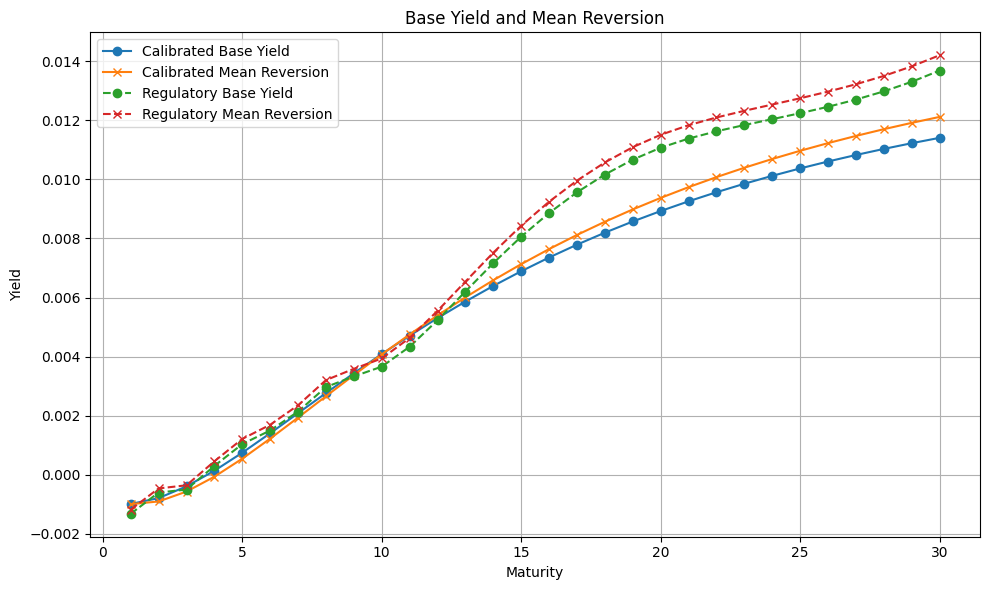

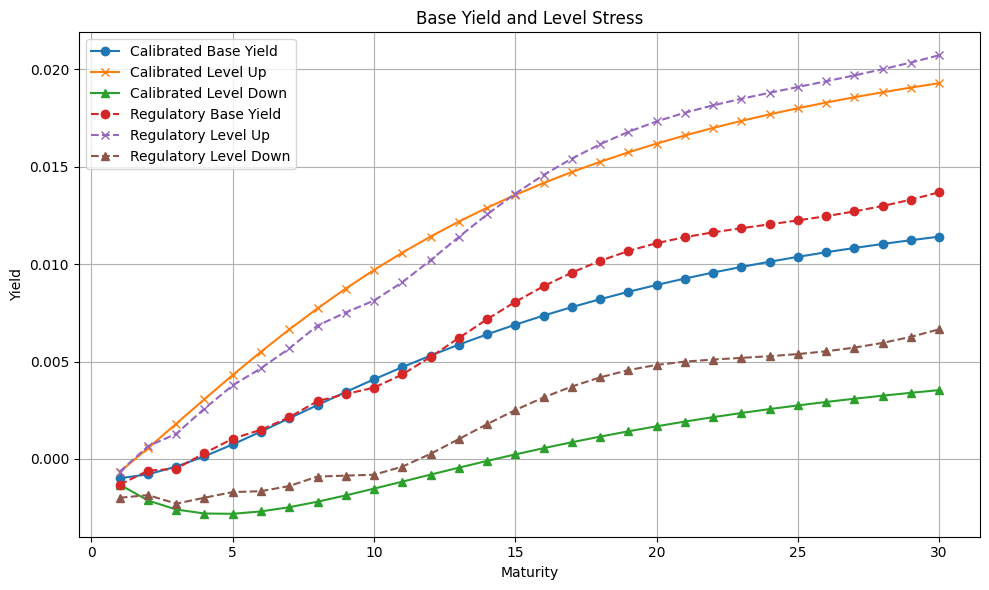

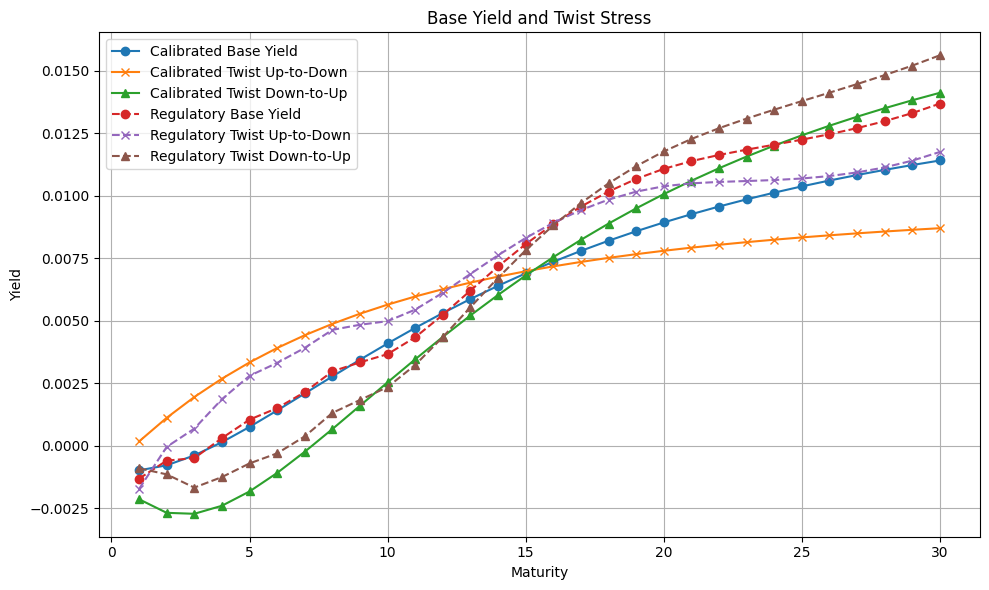

In [11]:
calibrated_file = 'DNS30_yield_curves_for_ICSrisk_202303_regulation.csv'
regulatory_file = 'ICS202303JPY_rf.csv'

df_calibrated = pd.read_csv(calibrated_file)
df_regulatory = pd.read_csv(regulatory_file)

yield_components = [col for col in df_calibrated.columns if col != 'Maturity']

df_calib = df_calibrated[df_calibrated['Maturity'] <= 30]
df_reg = df_regulatory[df_regulatory['Maturity'] <= 30]

plt.figure(figsize=(10, 6))
plt.plot(df_calib["Maturity"], df_calib["Base Yield"], marker='o', linestyle='-', label="Calibrated Base Yield")
plt.plot(df_calib["Maturity"], df_calib["Mean Reversion"], marker='x', linestyle='-', label="Calibrated Mean Reversion")
plt.plot(df_reg["Maturity"], df_reg["Base Yield"], marker='o', linestyle='--', label="Regulatory Base Yield")
plt.plot(df_reg["Maturity"], df_reg["Mean Reversion"], marker='x', linestyle='--', label="Regulatory Mean Reversion")
plt.title("Base Yield and Mean Reversion")
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_calib["Maturity"], df_calib["Base Yield"], marker='o', linestyle='-', label="Calibrated Base Yield")
plt.plot(df_calib["Maturity"], df_calib["Level Up"], marker='x', linestyle='-', label="Calibrated Level Up")
plt.plot(df_calib["Maturity"], df_calib["Level Down"], marker='^', linestyle='-', label="Calibrated Level Down")
plt.plot(df_reg["Maturity"], df_reg["Base Yield"], marker='o', linestyle='--', label="Regulatory Base Yield")
plt.plot(df_reg["Maturity"], df_reg["Level Up"], marker='x', linestyle='--', label="Regulatory Level Up")
plt.plot(df_reg["Maturity"], df_reg["Level Down"], marker='^', linestyle='--', label="Regulatory Level Down")
plt.title("Base Yield and Level Stress")
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_calib["Maturity"], df_calib["Base Yield"], marker='o', linestyle='-', label="Calibrated Base Yield")
plt.plot(df_calib["Maturity"], df_calib["Twist Up-to-Down"], marker='x', linestyle='-', label="Calibrated Twist Up-to-Down")
plt.plot(df_calib["Maturity"], df_calib["Twist Down-to-Up"], marker='^', linestyle='-', label="Calibrated Twist Down-to-Up")
plt.plot(df_reg["Maturity"], df_reg["Base Yield"], marker='o', linestyle='--', label="Regulatory Base Yield")
plt.plot(df_reg["Maturity"], df_reg["Twist Up-to-Down"], marker='x', linestyle='--', label="Regulatory Twist Up-to-Down")
plt.plot(df_reg["Maturity"], df_reg["Twist Down-to-Up"], marker='^', linestyle='--', label="Regulatory Twist Down-to-Up")
plt.title("Base Yield and Twist Stress")
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

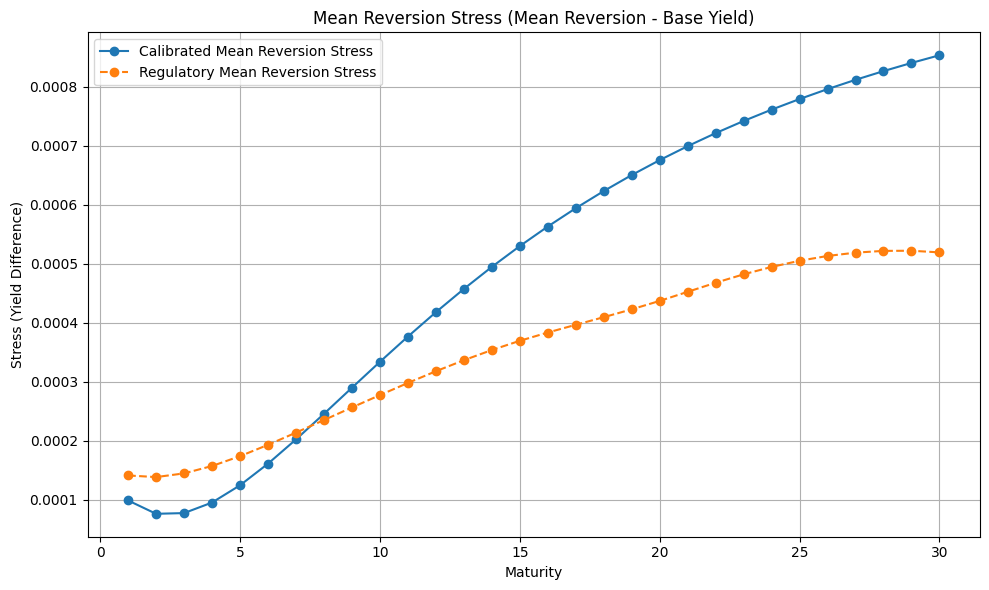

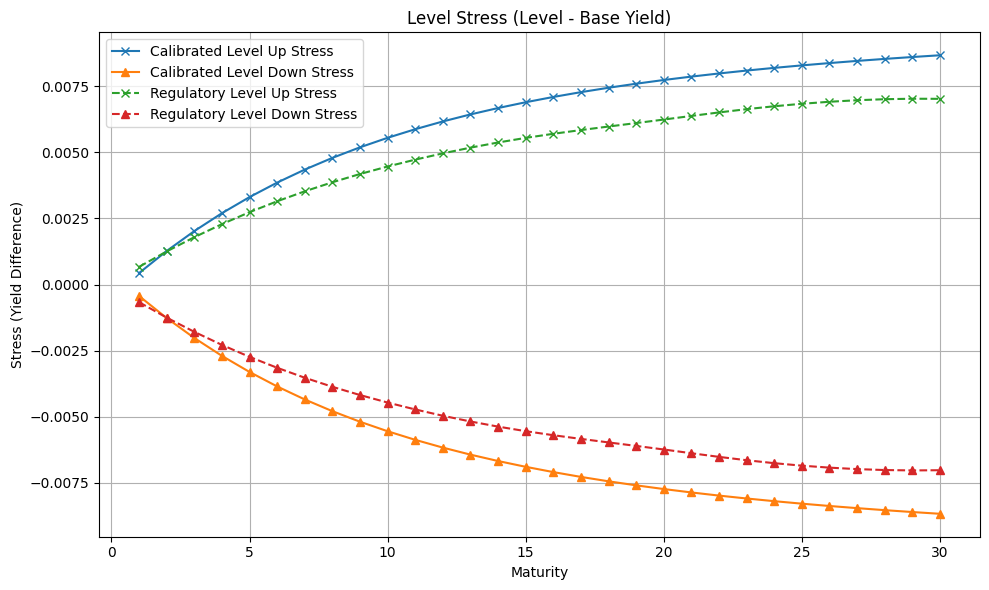

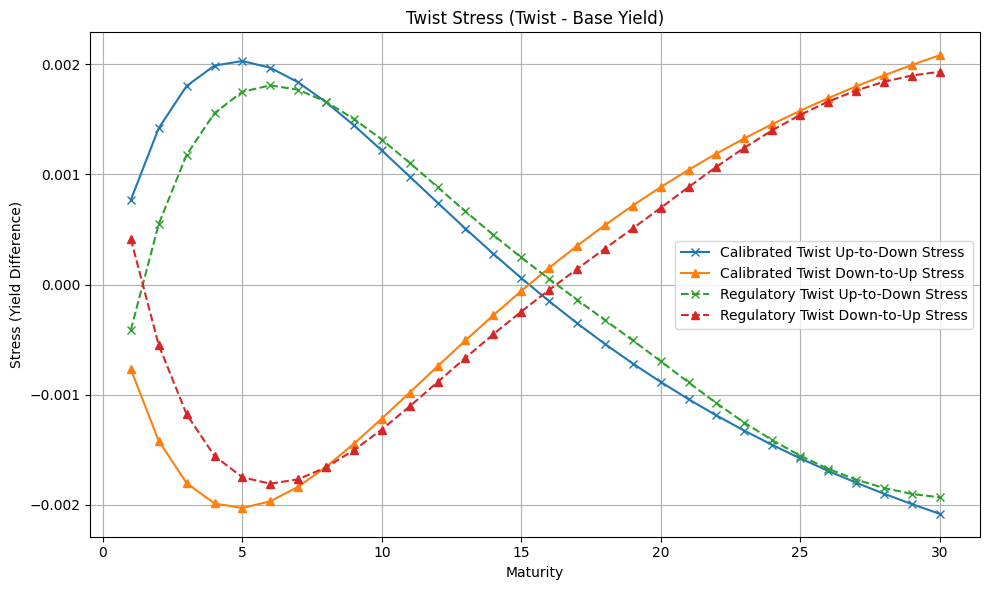

In [9]:
plt.figure(figsize=(10, 6))

stress_calib_mean = df_calib["Mean Reversion"] - df_calib["Base Yield"]
stress_reg_mean = df_reg["Mean Reversion"] - df_reg["Base Yield"]

plt.plot(df_calib["Maturity"], stress_calib_mean, marker='o', linestyle='-', 
         label="Calibrated Mean Reversion Stress")
plt.plot(df_reg["Maturity"], stress_reg_mean, marker='o', linestyle='--', 
         label="Regulatory Mean Reversion Stress")

plt.title("Mean Reversion Stress (Mean Reversion - Base Yield)")
plt.xlabel("Maturity")
plt.ylabel("Stress (Yield Difference)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
stress_calib_level_up = df_calib["Level Up"] - df_calib["Base Yield"]
stress_calib_level_down = df_calib["Level Down"] - df_calib["Base Yield"]
stress_reg_level_up = df_reg["Level Up"] - df_reg["Base Yield"]
stress_reg_level_down = df_reg["Level Down"] - df_reg["Base Yield"]

plt.plot(df_calib["Maturity"], stress_calib_level_up, marker='x', linestyle='-', 
         label="Calibrated Level Up Stress")
plt.plot(df_calib["Maturity"], stress_calib_level_down, marker='^', linestyle='-', 
         label="Calibrated Level Down Stress")
plt.plot(df_reg["Maturity"], stress_reg_level_up, marker='x', linestyle='--', 
         label="Regulatory Level Up Stress")
plt.plot(df_reg["Maturity"], stress_reg_level_down, marker='^', linestyle='--', 
         label="Regulatory Level Down Stress")

plt.title("Level Stress (Level - Base Yield)")
plt.xlabel("Maturity")
plt.ylabel("Stress (Yield Difference)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
stress_calib_twist_up_down = df_calib["Twist Up-to-Down"] - df_calib["Base Yield"]
stress_calib_twist_down_up = df_calib["Twist Down-to-Up"] - df_calib["Base Yield"]
stress_reg_twist_up_down = df_reg["Twist Up-to-Down"] - df_reg["Base Yield"]
stress_reg_twist_down_up = df_reg["Twist Down-to-Up"] - df_reg["Base Yield"]

plt.plot(df_calib["Maturity"], stress_calib_twist_up_down, marker='x', linestyle='-', 
         label="Calibrated Twist Up-to-Down Stress")
plt.plot(df_calib["Maturity"], stress_calib_twist_down_up, marker='^', linestyle='-', 
         label="Calibrated Twist Down-to-Up Stress")
plt.plot(df_reg["Maturity"], stress_reg_twist_up_down, marker='x', linestyle='--', 
         label="Regulatory Twist Up-to-Down Stress")
plt.plot(df_reg["Maturity"], stress_reg_twist_down_up, marker='^', linestyle='--', 
         label="Regulatory Twist Down-to-Up Stress")

plt.title("Twist Stress (Twist - Base Yield)")
plt.xlabel("Maturity")
plt.ylabel("Stress (Yield Difference)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()